In [27]:
from pathlib import Path
from scipy.signal import find_peaks
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable
import h5py
import copy
import pickle

# Project modules
from lib.Stokes import Stokes
from functions.plot_data import plot_data
from functions.plot_angle_gradient import plot_angle_gradient

In [2]:
# Open data files
from functions.load_pickles import load_pickles
stokes_list, _ = load_pickles(select="stokes")

Loading Stokes data from file generated/objects/stokes.pickle


In [3]:
# Extract each Stokes parameter into dictionary, to make it easier to work with
I = stokes_list['I']
Q = stokes_list['Q']
U = stokes_list['U']
V = stokes_list['V']

In [28]:
def noise_level(a):
    a = np.asanyarray(a)
    sd = a.std(ddof=1)
    return sd

# Example spectrum noise level
spectrum = copy.copy(I.data_n[100,100,:])
sd = noise_level(spectrum[90:])
print(f'Noise level = {sd}')

Noise level = 0.005434881895780563


In [5]:
lambda0  = [6301.51, 6302.50]   # Angstroms to cm

Mean = 0.9371117949485779, Std = 0.1991632729768753


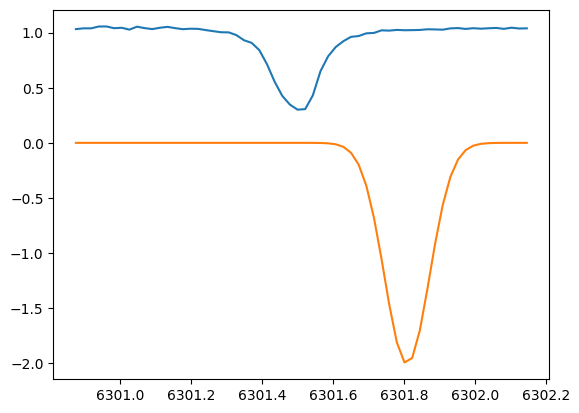

In [84]:
mean,std = norm.fit(I.data_n[0,0,:60])  # (mu, sigma)
print(f'Mean = {mean}, Std = {std}')


# plt.plot(I.wave_array[:60], norm.pdf(np.linspace(1,2,60), mean, std))
plt.plot(I.wave_array[:60], I.data_n[0,0,:60])
plt.plot(I.wave_array[:60], -norm.pdf(np.linspace(-2,2,60), mean, std))


Mean = 0.9371117949485779, Std = 0.1991632729768753


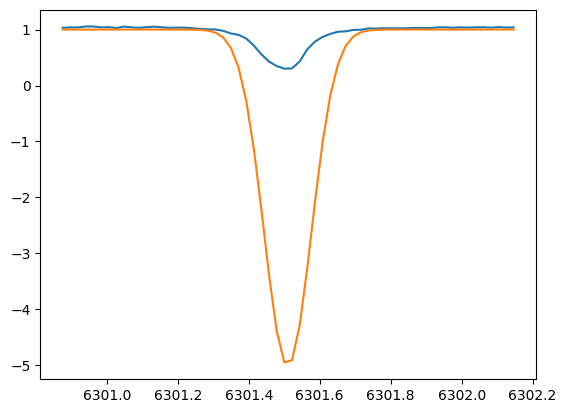

In [134]:
data = I.data_n[0,0,:60]
mean,std=norm.fit(data)
print(f'Mean = {mean}, Std = {std}')
plt.plot(I.wave_array[:60], data)
x = I.wave_array[:60]
std = std/3
y = 1 - 1/(std * np.sqrt(2 * np.pi)) * np.exp( - (x - lambda0[0])**2 / (2 * std**2) )
plt.plot(x, y)
plt.show()

In [136]:
fitter = modeling.fitting.LevMarLSQFitter()
model = modeling.models.Gaussian1D()   # depending on the data you need to give some initial values
fitted_model = fitter(model, I.wave_array[:60], -I.data_n[0,0,:60]-1)

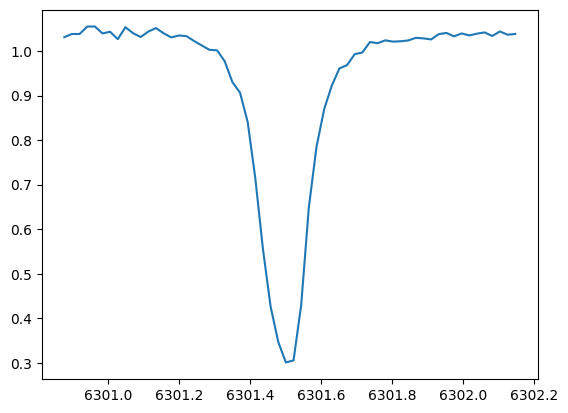

In [137]:
plt.plot(I.wave_array[:60], I.data_n[0,0,:60])

In [90]:
from astropy import modeling

Minimum of Gaussian fit: x = 6301.497126396685, y = 0.2957284450531006


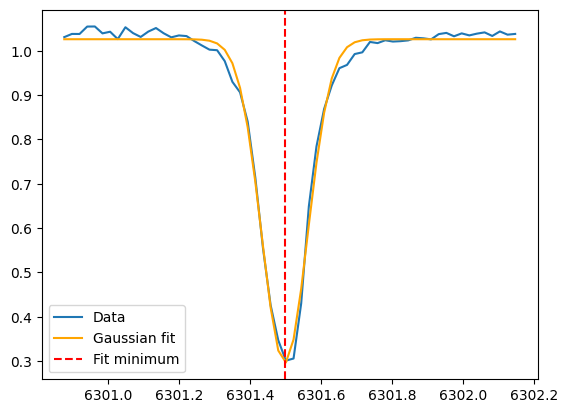

In [143]:
# Fit a Gaussian to the data and find its minimum
from astropy.modeling import models, fitting

x = I.wave_array[:60]
y = I.data_n[0,0,:60]

# Normalize y for fitting stability
y_norm = (y - np.median(y)) / np.abs(y).max()

# Initial guess: amplitude, mean, stddev
amplitude_guess = y_norm.min()
mean_guess = x[np.argmin(y_norm)]
stddev_guess = (x.max() - x.min()) / 8

init = models.Gaussian1D(amplitude=amplitude_guess, mean=mean_guess, stddev=stddev_guess)
fitter = fitting.LevMarLSQFitter()
fit = fitter(init, x, y_norm)

min_x = fit.mean.value
min_y = fit(min_x) * np.abs(y).max() + np.median(y)  # convert back to original scale

print(f"Minimum of Gaussian fit: x = {min_x}, y = {min_y}")

plt.plot(x, y, label='Data')
plt.plot(x, fit(x) * np.abs(y).max() + np.median(y), label='Gaussian fit', color='orange')
plt.axvline(min_x, color='red', linestyle='--', label='Fit minimum')
plt.legend()
plt.show()

In [144]:
# Calculate the wavelength of the minimum of the Gaussian fit for each pixel
from astropy.modeling import models, fitting

shape = I.data_n.shape[:2]
lambda_min = np.full(shape, np.nan)

for i in range(shape[0]):
    for j in range(shape[1]):
        y = I.data_n[i, j, :60]
        x = I.wave_array[:60]
        # Initial guess: amplitude, mean, stddev
        amplitude_guess = y.min()
        mean_guess = x[np.argmin(y)]
        stddev_guess = (x.max() - x.min()) / 8
        init = models.Gaussian1D(amplitude=amplitude_guess, mean=mean_guess, stddev=stddev_guess)
        fitter = fitting.LevMarLSQFitter()
        try:
            fit = fitter(init, x, y)
            lambda_min[i, j] = fit.mean.value
        except Exception:
            lambda_min[i, j] = np.nan

print('Shape of lambda_min:', lambda_min.shape)
# Example: plot the result for a region
plt.imshow(lambda_min, origin='lower', cmap='viridis')
plt.colorbar(label='Wavelength of Gaussian minimum')
plt.title('Wavelength of minimum for each pixel')
plt.show()

KeyboardInterrupt: 

Row 300 of 768
For pixel 300,300:
Noise level = 0.003949331119656563
Low threshold = 0.6076444983482361
Minimum positions: [30, 76]
Line 1 minimum: 6301.52213044407
Distance: -0.012130 Angstrom
Line 2 minimum: 6302.512745933525
Distance: -0.012746 Angstrom
For pixel 300,301:
Noise level = 0.003494816832244396
Low threshold = 0.6262551546096802
Minimum positions: [30, 75]
Line 1 minimum: 6301.52213044407
Distance: -0.012130 Angstrom
Line 2 minimum: 6302.491210814189
Distance: 0.008789 Angstrom
For pixel 300,302:
Noise level = 0.003759182058274746
Low threshold = 0.6290627717971802
Minimum positions: [31, 75]
Line 1 minimum: 6301.543665563406
Distance: -0.033666 Angstrom
Line 2 minimum: 6302.491210814189
Distance: 0.008789 Angstrom
For pixel 300,303:
Noise level = 0.004312959499657154
Low threshold = 0.6290451288223267
Minimum positions: [31, 75]
Line 1 minimum: 6301.543665563406
Distance: -0.033666 Angstrom
Line 2 minimum: 6302.491210814189
Distance: 0.008789 Angstrom
For pixel 300,304:

/tmp/ipykernel_1194/3036911502.py:41: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


Line 1 minimum: 6301.479060205398
Distance: 0.030940 Angstrom
Line 2 minimum: 6302.512745933525
Distance: -0.012746 Angstrom
For pixel 304,304:
Noise level = 0.006148514803498983
Low threshold = 0.6652355790138245
Minimum positions: [27, 76]
Line 1 minimum: 6301.457525086062
Distance: 0.052475 Angstrom
Line 2 minimum: 6302.512745933525
Distance: -0.012746 Angstrom


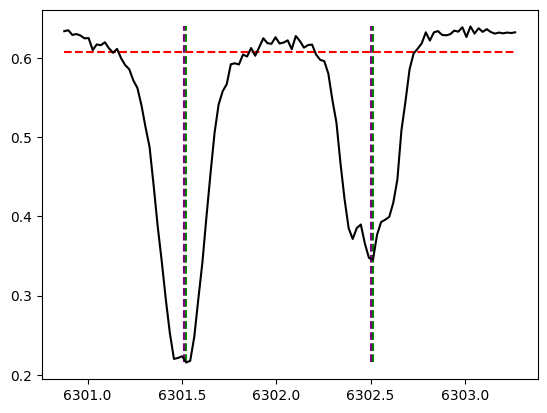

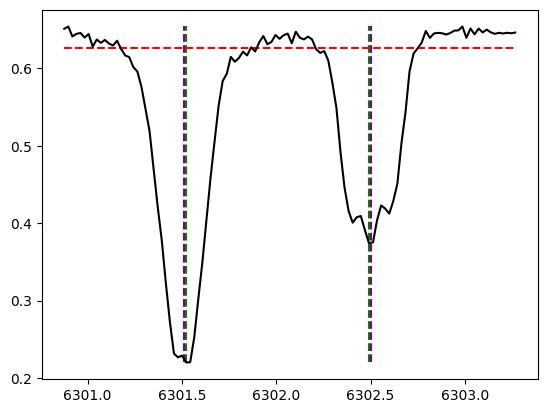

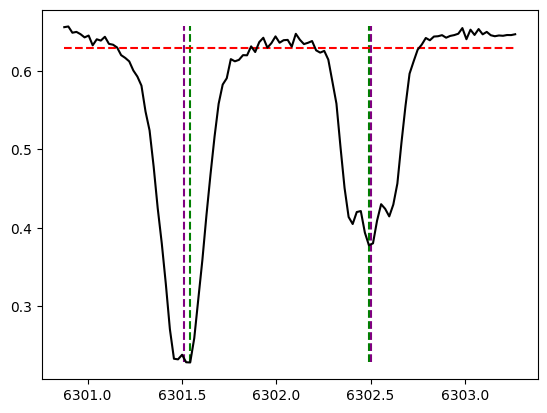

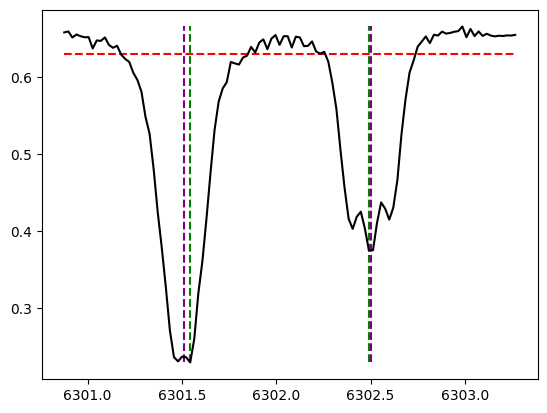

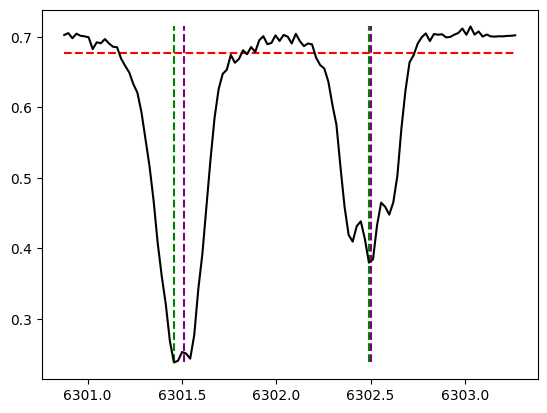

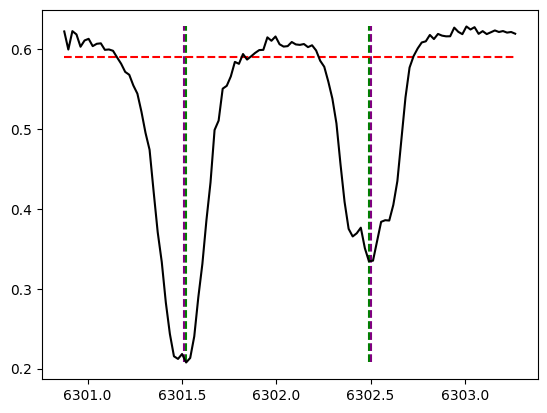

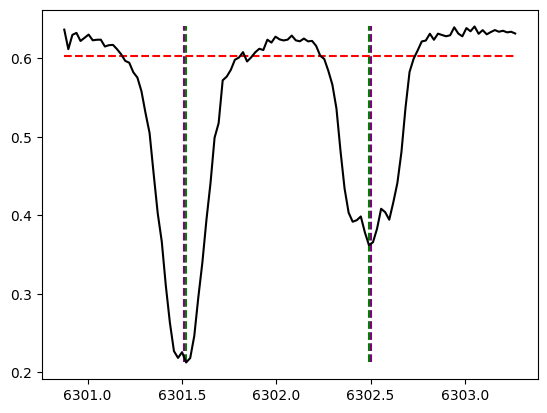

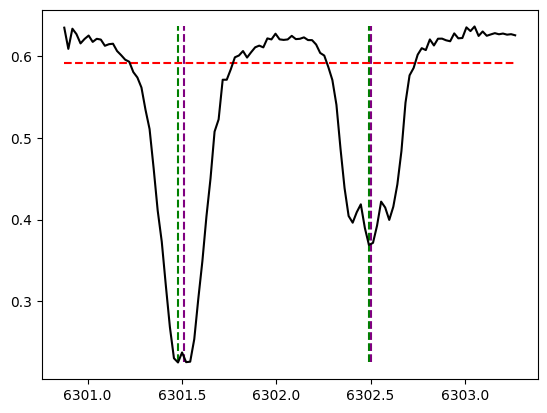

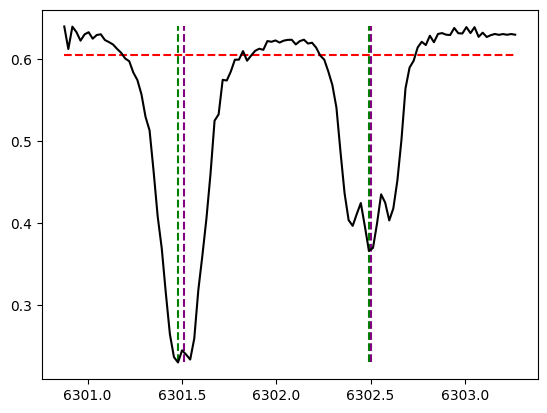

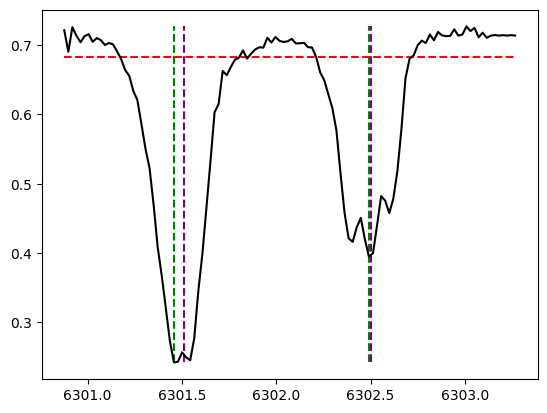

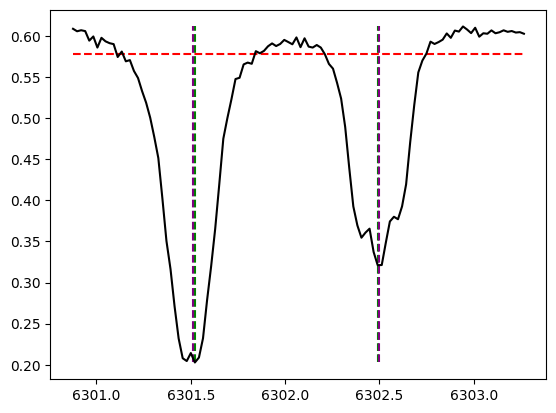

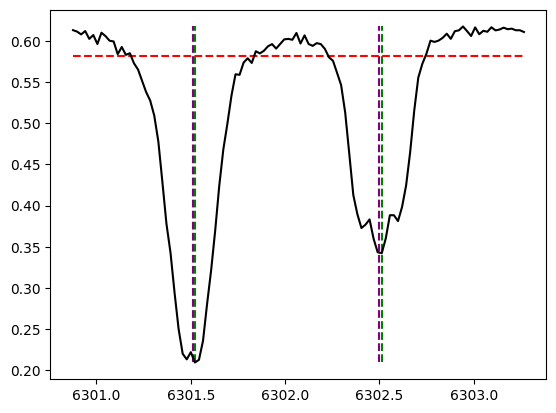

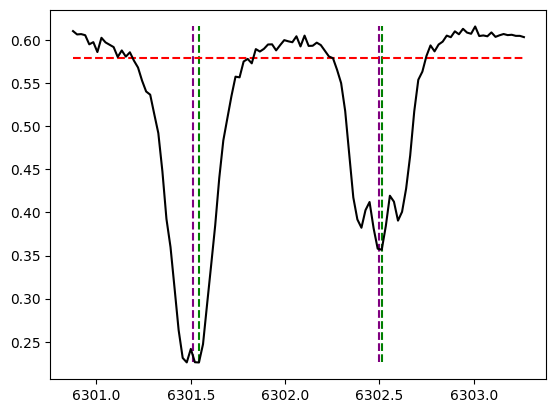

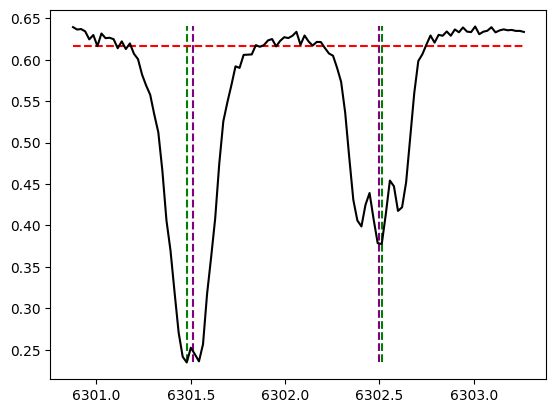

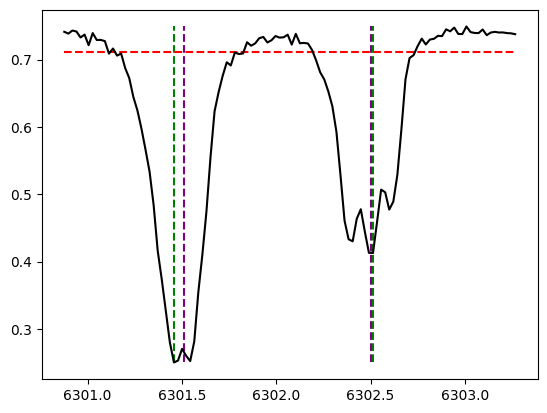

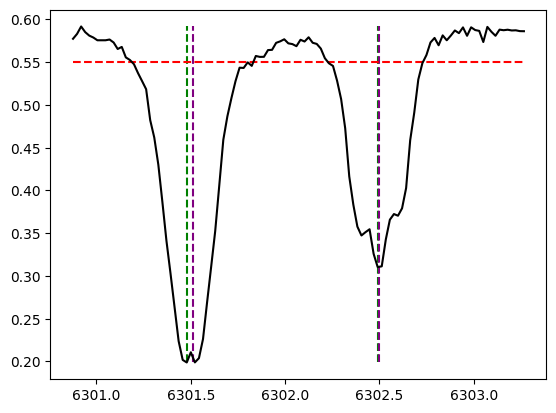

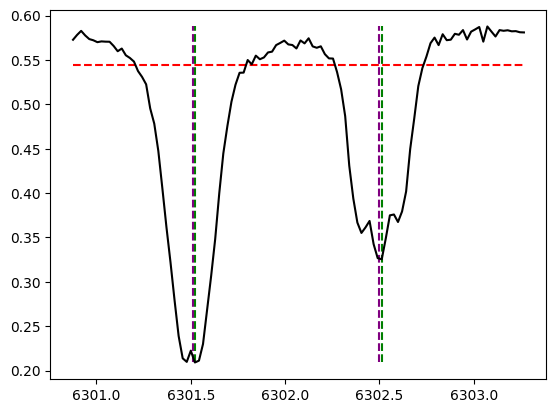

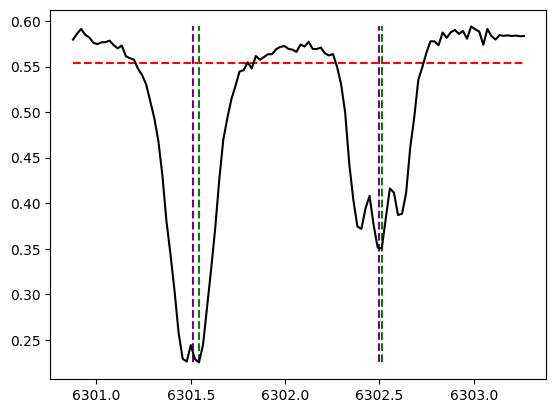

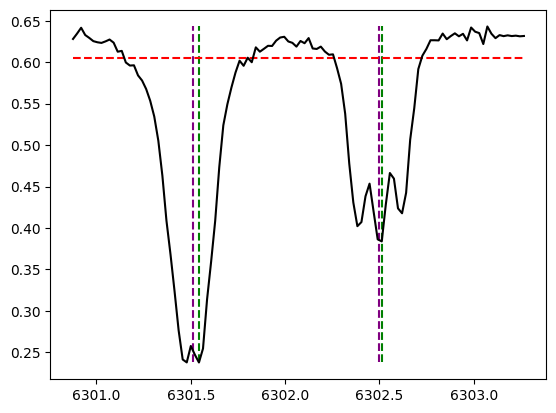

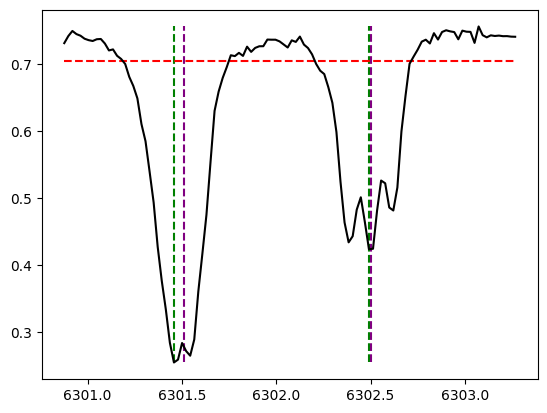

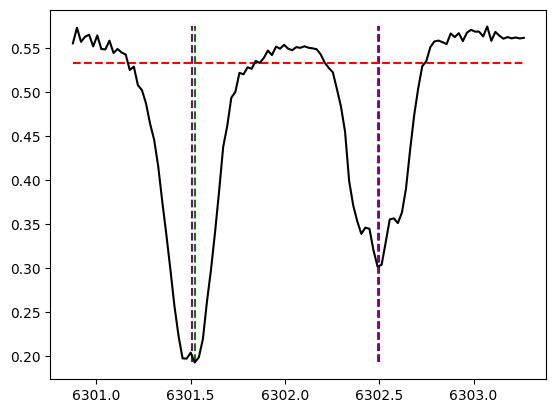

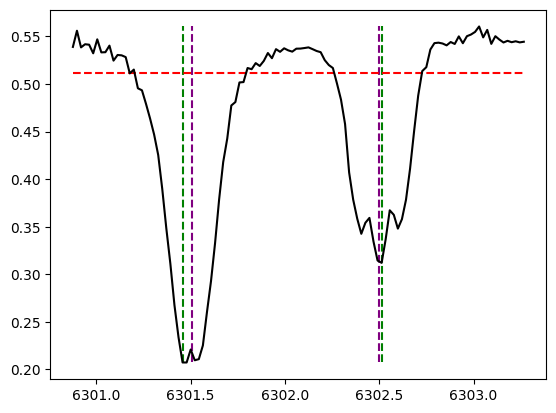

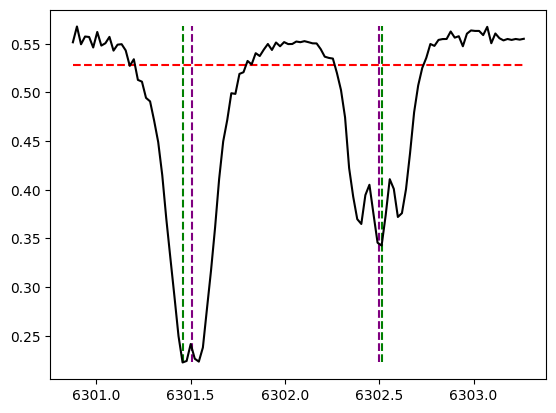

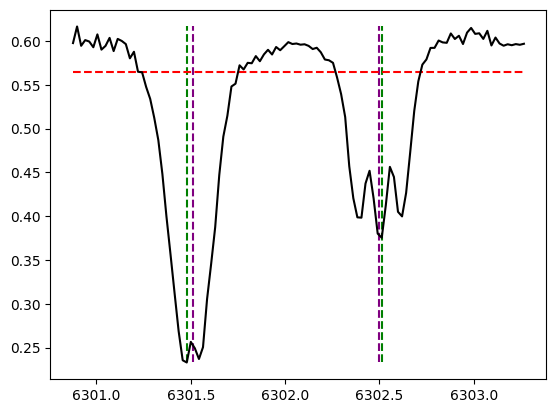

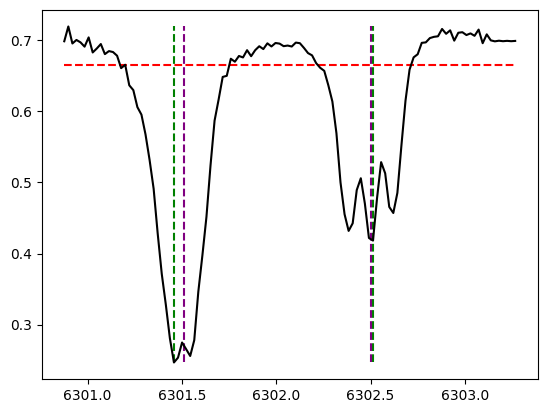

In [ ]:
# Calculate delta lambda (distance between I minimum and spectral line reference)

dl = np.zeros(I.data.shape)[:,:,:2].astype(float)
dl_binary = np.zeros(I.data.shape)[:,:,:2].astype(float)
margin = 6
verbose = 1

for i in range(300,305):
# for i in range(0, np.shape(I.data_n)[0]):

    # Read out every 50 rows
    if np.mod(i,50) == 0:
        print(f'Row {i} of {np.shape(I.data_n)[0]}')

    for j in range(300,305):
    # for j in range(0, np.shape(I.data_n)[1]):
        if (verbose):
            print(f'For pixel {i},{j}:')

        # Initialize variables
        peaks_n = [0, 0]

        # Get the spectrum for this pixel
        spectrum = copy.copy(I.data_n[i,j,:])

        # Calculate noise level for spectrum region outside the spectral lines
        sd = noise_level(spectrum[90:])
        low_threshold = (spectrum[:5].mean() - margin*sd)
        if (verbose):
            print(f'Noise level = {sd}')
            print(f'Low threshold = {low_threshold}')

        # First line
        peaks_n[0] = int(np.argmin(spectrum[:60])) if spectrum[:60].min() < low_threshold else None

        # # Second line
        peaks_n[1] = 60 + int(np.argmin(spectrum[60:])) if spectrum[60:].min() < low_threshold else None

        if (verbose):
            print(f'Minimum positions: {peaks_n}')
            plt.figure()

        # If minimum has been found calculate dl
        for k in range(2):
            if peaks_n[k] is not None:
                dl_binary[i, j, k] = 1
                dl[i, j, k] = lambda0[k] - np.array(I.wave_array)[peaks_n[k]]

                if (verbose):
                    plt.vlines(I.wave_array[peaks_n[k]], ymin=np.min(spectrum), ymax=np.max(spectrum), color='g', linestyle='--')
                    plt.vlines(lambda0[k], ymin=np.min(spectrum), ymax=np.max(spectrum), color='purple', linestyle='--')
                    print(f'Line {k+1} minimum: {I.wave_array[peaks_n[k]]}')
                    print(f'Distance: {dl[i, j, k]:.6f} Angstrom')
            else:
                dl[i, j, k] = np.nan

        if (verbose):
            plt.hlines(low_threshold, I.wave_array[0], I.wave_array[-1], color='red', linestyle='--')
            plt.plot(I.wave_array, spectrum, linestyle='-', color='black')

In [ ]:
plot_data(dlB[:,:,0], title=r"$\Delta \lambda _B$, in $\mathrm{\AA}$")

In [ ]:
plot_data(Bv[:,:,0], title=r"$B$, in G$")

In [ ]:
# Calculate strong magnetic field
B_strong = dlB / (2 * C * np.array(lambda0)**2 * np.array(gbar))

In [ ]:
Bv = np.moveaxis(Bv, 0, -1)
Bt = np.moveaxis(Bt, 0, -1)

In [ ]:
# Constants
kB = 1.3806488e-16 # [erg K-1]
h = 6.6260755e-27  # [erg s]
c = 2.99792458e10  # [cm · s−1]
lambda0  = np.array([6301.51*1e-8, 6302.50*1e-8])   # Angstroms to cm
l = np.mean(lambda0)
Icont = I.data_n[:,:,:5].mean(axis=2) # I map in continuum
Teff = 5780 # [K] T quiet sun average
T = (1/Teff - kB*l/(h*c) * np.log(Icont))**-1
M = 55.845 # Fe atomic mass, [g mol-1]
av = 6.022e23 # avogadro, [mol-1]
m =  M/av
Xi = 0 # microturbulence, assumed 0

# Rebecca Centeno, equation 3
dlD = np.array([6301.5/c * np.sqrt(2*kB*T/m + Xi**2), 6302.5/c * np.sqrt(2*kB*T/m + Xi**2)]) # will be in units of lambda, in this case Angstrom

dlD = np.moveaxis(dlD, 0, -1)
np.shape(dlD)
# plot_data(dlD[:,:,0], title=r"$\Delta \lambda _D$, in $\mathrm{\AA}$")

In [ ]:
# remove outliers
B_strong[B_strong > 5000] = np.nan
B_strong[B_strong < -5000] = np.nan

In [ ]:
B = np.empty(Bv.shape)
B[:,:,:] = np.nan
B_mask = np.zeros(Bv.shape) * np.nan
# gamma = np.zeros(derived.weak.Bv.shape) * np.nan
# chi = np.zeros(derived.weak.Bv.shape) * np.nan

for i in range(I.data.shape[0]):
    for j in range(I.data.shape[1]):
        for k in range(0,2):
            if (dlB_binary[i,j,k] == 0) or np.isnan(dlB[i,j,k]) or (np.abs(dlB[i,j,k]) < np.abs(dlD[i,j,k])):
                # If dlB could not be calculated, or if it is less than the doppler effect
                B[i,j,k] = np.sqrt(Bv[i,j,k]**2 + Bt[i,j,k]**2)
                B_mask[i,j,k] = 0
                # chi[i,j,k] = derived.weak.chi[i,j,k]
                # gamma[i,j,k] = derived.weak.gamma[i,j,k]
            else:
                # Use strong field approximation otherwise
                B[i,j,k] = B_strong[i,j,k]
                B_mask[i,j,k] = 1
                # chi[i,j,k] = derived.strong.chi[i,j,k]
                # gamma[i,j,k] = derived.strong.gamma[i,j,k]

In [ ]:
print(np.abs(dlD[300,300,0]))
print(np.abs(dlB[300,300,0]))

In [ ]:
# Histogram of derived.strong.B[:,:,0]
plt.figure()
plt.hist(dlB[:,:,0].ravel(), bins=100, color='blue', alpha=0.7)
plt.xlabel('Magnetic field strength (first line)')
plt.ylabel('Count')
plt.title('Histogram of dlB[:,:,0]')
plt.show()

In [ ]:
# Histogram of derived.strong.B[:,:,0]
plt.figure()
plt.hist(B[:,:,0].ravel(), bins=100, color='blue', alpha=0.7)
plt.xlabel('Magnetic field strength (first line)')
plt.ylabel('Count')
plt.title('Histogram of B[:,:,0]')
plt.show()

In [ ]:
# remove outliers
dlB[dlB > 0.27] = np.nan
dlB[dlB < -0.27] = np.nan

In [ ]:
plot_data(dlB[:,:,0], colourmap='berlin', title=r"$\Delta \lambda _B$, 6301.5 $\mathrm{\AA}$, in $\mathrm{\AA}$")

In [ ]:
plot_data(B[:,:,0], colourmap='PuOr', title=r"B combined [G]")

In [ ]:
plot_data(dlB[:,:,0] > dlD[:,:,0], colourmap='grey')